In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_predict,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,mean_squared_error,accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
import time
from sklearn.feature_selection import VarianceThreshold
from imblearn.pipeline import Pipeline
from sklearn import neighbors
from sklearn.svm import SVC # "Support vector classifier"


### Εισαγωγή dataset από αρχείο CSV

In [2]:
data = pd.read_csv("./Dry_Bean.csv")

## Εξαγωγή πληροφοριών του dataset

In [3]:
n_samples=data.shape[0]
n_features = data.shape[1] - 1

In [4]:
x = data.drop('Class',axis=1)
y = data[["Class"]]

## train-test split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,test_size=0.2, random_state=0)

In [7]:
#x_train = StandardScaler().fit_transform(x_train)
#x_test = StandardScaler().fit_transform(x_test)

y_train =  np.ravel(y_train)
y_test = np.ravel(y_test)

x = np.append(x_train, x_test).reshape(13611,16)
y = np.append(y_train, y_test)

In [ ]:
# hold times for train and pred of out of the box
train_time_base = {}
pred_time_base = {}
# dictionary to store all classifier without optimization preds
predictions = {}

## Εκτέλεση MLP Out-of-the-box

In [ ]:
clf = MLPClassifier()
start_time = time.time()
clf.fit(x_train, y_train)
train_time_base["MLP"] = time.time() - start_time
start_time = time.time()
preds = clf.predict(x_test)
pred_time_base["MLP"] = time.time() - start_time
predictions["MLP"] = preds
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

    BARBUNYA       0.00      0.00      0.00       255
      BOMBAY       1.00      0.99      0.99        92
        CALI       0.53      0.98      0.69       350
    DERMASON       0.60      1.00      0.75       735
       HOROZ       0.97      0.68      0.80       390
       SEKER       0.00      0.00      0.00       376
        SIRA       0.68      0.62      0.65       525

    accuracy                           0.65      2723
   macro avg       0.54      0.61      0.55      2723
weighted avg       0.53      0.65      0.56      2723



C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.p

In [ ]:
scores_MLP_acc = cross_val_score(clf,x_train,y_train,cv=10,n_jobs=-1, scoring='accuracy')
scores_MLP_f1 = cross_val_score(clf,x_train,y_train,cv=10,n_jobs=-1,scoring='f1_weighted')

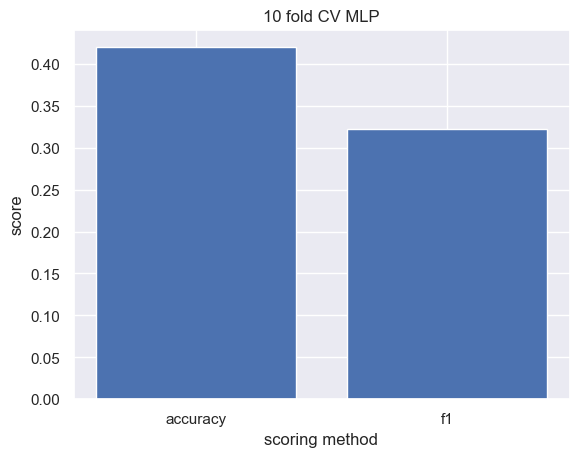

In [ ]:
plt.bar(['accuracy','f1'],[np.mean(scores_MLP_acc),np.mean(scores_MLP_f1)])
plt.xlabel("scoring method")
plt.ylabel("score")
plt.title("10 fold CV MLP")
plt.show()

## Εκτέλεση SVM Out-of-the-box

In [ ]:

model = SVC()
start_time = time.time()
model.fit(x_train, y_train)
train_time_base["SVM"] = time.time() - start_time
start_time = time.time()
preds =model.predict(x_test)
pred_time_base["SVM"] = time.time() - start_time
predictions["SVM"] = preds
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

    BARBUNYA       0.35      0.08      0.13       255
      BOMBAY       1.00      1.00      1.00        92
        CALI       0.62      0.84      0.72       350
    DERMASON       0.78      0.87      0.82       735
       HOROZ       0.60      0.57      0.59       390
       SEKER       0.37      0.23      0.29       376
        SIRA       0.58      0.74      0.65       525

    accuracy                           0.64      2723
   macro avg       0.61      0.62      0.60      2723
weighted avg       0.61      0.64      0.61      2723



In [ ]:
scores_SVM_acc = cross_val_score(model,x_train,y_train,cv=10,n_jobs=-1, scoring='accuracy')
scores_SVM_f1 = cross_val_score(model,x_train,y_train,cv=10,n_jobs=-1,scoring='f1_macro')

In [ ]:
plt.bar(['accuracy','f1'],[np.mean(scores_SVM_acc),np.mean(scores_SVM_f1)])
plt.xlabel("scoring method")
plt.ylabel("score")
plt.title("10 fold CV SVM")
plt.show()

## Dummy Classifiers for scale

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,f1_score

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

accuracy = {}
f1 = {}

def metrics_info(classifier_name, preds):
  global accuracy, f1 
  accuracy[classifier_name] = accuracy_score(y_test, preds)
  f1[classifier_name] = f1_score(y_test, preds, average = "macro")
  # print bar plot function
def bar_plot(classifiers, scores, title):
  plt.figure(figsize = (10,6))
  y_pos = np.arange(len(classifiers))
  plt.bar(y_pos, scores, align='center', alpha = 0.9)
  plt.xticks(y_pos, classifiers, rotation = 45)
  plt.ylabel('Score')
  plt.title(title)
  plt.show()

In [ ]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_horoz = DummyClassifier(strategy="constant", constant='horoz'.upper())
dc_constant_sira = DummyClassifier(strategy="constant", constant= 'sira'.upper())
dc_constant_barbunya = DummyClassifier(strategy="constant", constant='barbunya'.upper())
dc_constant_seker = DummyClassifier(strategy="constant", constant='seker'.upper())
dc_constant_bombay = DummyClassifier(strategy="constant",constant='bombay'.upper())
dc_constant_cali = DummyClassifier(strategy="constant",constant='cali'.upper())
dc_constant_dermason = DummyClassifier(strategy="constant",constant='dermason'.upper())
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

# with the fit method we train the classifier with the train set
# with the predict method predictions occur based on the input data
start_time = time.time()
dc_uniform.fit(x_train, y_train)
train_time_base["DC Uniform"] = time.time() - start_time
start_time = time.time()
predictions["DC Uniform"] = dc_uniform.predict(x_test)
pred_time_base["DC Uniform"] = time.time() - start_time
start_time = time.time()
dc_constant_horoz.fit(x_train, y_train)
train_time_base["DC Constant horoz"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant horoz"] = dc_constant_horoz.predict(x_test)
pred_time_base["DC Constant horoz"] = time.time() - start_time
start_time = time.time()
dc_constant_sira.fit(x_train, y_train)
train_time_base["DC Constant sira"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant sira"] = dc_constant_sira.predict(x_test)
pred_time_base["DC Constant sira"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_bombay.fit(x_train, y_train)
train_time_base["DC Constant bombay"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant bombay"] = dc_constant_bombay.predict(x_test)
pred_time_base["DC Constant bombay"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_cali.fit(x_train, y_train)
train_time_base["DC Constant cali"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant cali"] = dc_constant_cali.predict(x_test)
pred_time_base["DC Constant cali"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_dermason.fit(x_train, y_train)
train_time_base["DC Constant dermason"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant dermason"] = dc_constant_dermason.predict(x_test)
pred_time_base["DC Constant dermason"] = time.time() - start_time
start_time = time.time()

dc_constant_barbunya.fit(x_train, y_train)
train_time_base["DC Constant barbunya"] = time.time() - start_time

start_time = time.time()
predictions["DC Constant barbunya"] = dc_constant_barbunya.predict(x_test)
pred_time_base["DC Constant barbunya"] = time.time() - start_time
start_time = time.time()
dc_constant_seker.fit(x_train, y_train)
train_time_base["DC Constant seker"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant seker"] = dc_constant_seker.predict(x_test)
pred_time_base["DC Constant seker"] = time.time() - start_time
start_time = time.time()
dc_most_frequent.fit(x_train, y_train)
train_time_base["DC Most Frequent"] = time.time() - start_time
start_time = time.time()
predictions["DC Most Frequent"] = dc_most_frequent.predict(x_test)
pred_time_base["DC Most Frequent"] = time.time() - start_time
start_time = time.time()
dc_stratified.fit(x_train, y_train)
train_time_base["DC Stratified"] = time.time() - start_time
start_time = time.time()
predictions["DC Stratified"] = dc_stratified.predict(x_test)
pred_time_base["DC Stratified"] = time.time() - start_time

metrics_info("MLP",predictions["MLP"])
metrics_info("SVM",predictions["SVM"])
metrics_info("DC Uniform", predictions["DC Uniform"])
metrics_info("DC Constant horoz", predictions["DC Constant horoz"])
metrics_info("DC Constant sira", predictions["DC Constant sira"])
metrics_info("DC Constant barbunya", predictions["DC Constant barbunya"])
metrics_info("DC Constant seker", predictions["DC Constant seker"])
metrics_info("DC Constant bombay", predictions["DC Constant bombay"])
metrics_info("DC Constant cali", predictions["DC Constant cali"])
metrics_info("DC Constant dermason", predictions["DC Constant dermason"])
metrics_info("DC Most Frequent", predictions["DC Most Frequent"])
metrics_info("DC Stratified", predictions["DC Stratified"])
classifier_labels = list(accuracy.keys())
classifier_accuracy = list(accuracy.values())
classifier_f1 = list(f1.values())
    
data = []
data.append(list(accuracy.values()))
data.append(list(f1.values()))
print(pd.DataFrame(data, index = ["Accuracy Score", "F1 Score"], columns = list(accuracy.keys())))

bar_plot(classifier_labels, [i*100 for i in classifier_accuracy], "Accuracy Score (Out of the box)")
bar_plot(classifier_labels, [i*100 for i in classifier_f1], "F1 Score (Out of the box)")



In [ ]:
dum = DummyClassifier()

In [ ]:
scores_DUM_acc = cross_val_score(dum,x_train,y_train,cv=10,n_jobs=-1, scoring='accuracy')
scores_DUM_f1 = cross_val_score(dum,x_train,y_train,cv=10,n_jobs=-1,scoring='f1_macro')

In [ ]:
plt.bar(['accuracy','f1'],[np.mean(scores_DUM_acc),np.mean(scores_DUM_f1)])
plt.xlabel("scoring method")
plt.ylabel("score")
plt.title("10 fold CV DUMMY")
plt.show()

## Improvement

### Preproccessing

In [ ]:
selector = VarianceThreshold(threshold=0.00001)
train_reduced = selector.fit_transform(x_train)
mask = selector.get_support()
test_reduced = np.array(x_test)[:,mask]
print("Features Used = {}".format(np.shape(test_reduced)[1]))

In [ ]:
clf = MLPClassifier()
start_time = time.time()
clf.fit(train_reduced, y_train)
train_time_base["MLP"] = time.time() - start_time
start_time = time.time()
preds = clf.predict(test_reduced)
pred_time_base["MLP"] = time.time() - start_time
predictions["MLP"] = preds
print(classification_report(y_test, preds))

In [ ]:
model = SVC()
start_time = time.time()
model.fit(train_reduced, y_train)
train_time_base["SVM"] = time.time() - start_time
start_time = time.time()
preds = model.predict(test_reduced)
pred_time_base["SVM"] = time.time() - start_time
predictions["SVM"] = preds
print(classification_report(y_test, preds))

### Pipeline

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler # φέρνουμε τον StandarScaler ως transformer που έχει .transform kai ΄όχι ως scale()
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

selector = VarianceThreshold(0.0001)
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()

pipe = Pipeline(steps = [('selector',selector),('scaler', scaler),('sampler',ros),('pca',pca),('clf',clf)], memory = 'tmp')
timer = time.time()
pipe.fit(x_train,y_train)
demo_fit_time = time.time() - timer
timer = time.time()
pred_mlp = pipe.predict(x_test)
demo_pred_time = time.time() - timer
print(classification_report(y_test, pred_mlp))

model = SVC()
pipe_svm = Pipeline(steps = [('selector',selector),('scaler', scaler),('sampler',ros),('pca',pca),('clf',model)], memory = 'tmp')
timer = time.time()
pipe_svm.fit(x_train,y_train)
demo_fit_time_svm = time.time() - timer
timer = time.time()
pred_svm = pipe_svm.predict(x_test)
demo_pred_time_svm = time.time() - timer
print(classification_report(y_test, pred_svm))


              precision    recall  f1-score   support

    BARBUNYA       0.95      0.92      0.93       255
      BOMBAY       1.00      1.00      1.00        92
        CALI       0.93      0.96      0.94       350
    DERMASON       0.93      0.93      0.93       735
       HOROZ       0.96      0.95      0.96       390
       SEKER       0.95      0.97      0.96       376
        SIRA       0.88      0.88      0.88       525

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723

              precision    recall  f1-score   support

    BARBUNYA       0.91      0.89      0.90       255
      BOMBAY       1.00      1.00      1.00        92
        CALI       0.93      0.93      0.93       350
    DERMASON       0.93      0.91      0.92       735
       HOROZ       0.96      0.94      0.95       390
       SEKER       0.94      0.95      0.94       376
        SIRA       0.85 

### GridSearch


In [ ]:
vthreshold = list(np.arange(start = 0, stop = 0.0002, step = 0.00005))
print(vthreshold)
n_components = [11,12,13,14]

In [ ]:
estimator_mlp_f1 = GridSearchCV(pipe, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='f1_macro', n_jobs=-1)
estimator_mlp_f1.fit(x_train,y_train)

In [ ]:
MLPF = estimator_mlp_f1.best_score_

In [ ]:
estimator_mlp_acc = GridSearchCV(pipe, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='accuracy', n_jobs=-1)
estimator_mlp_acc.fit(x_train,y_train)

In [ ]:
MLPA = estimator_mlp_acc.best_score_

In [ ]:
estimator_svm_f1 = GridSearchCV(pipe_svm, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='f1_macro', n_jobs=-1)
estimator_svm_f1.fit(x_train,y_train)

In [ ]:
SVMF = estimator_svm_f1.best_score_
SVMF

In [ ]:
estimator_svm_acc = GridSearchCV(pipe_svm, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='accuracy', n_jobs=-1)
estimator_svm_acc.fit(x_train,y_train)

In [ ]:
SVMA = estimator_svm_acc.best_score_

In [ ]:
scores = [MLPF*100,MLPA*100,SVMF*100,SVMA*100]
names = ["MLP f1","MLP accuracy","SVM f1","SVM accuracy"]

In [ ]:
plt.bar(names,scores)
plt.show()
for i in range(len(scores)):
    print("CLASSIFIRER {} --> {}".format(names[i],scores[i]))

## OPTUNA



In [8]:
import optuna
import sklearn.datasets
from sklearn.datasets import fetch_openml
import sklearn.neural_network

def objective(trial):
    vr = VarianceThreshold(0.0001)
    sc = StandardScaler()
    #ros = RandomOverSampler()
  
    x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,test_size=0.2, random_state=0)
    y_train =  np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    x_train = vr.fit_transform(x_train)
    mask = vr.get_support()
    x_test = np.array(x_test)[:,mask]

    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)

    # x_train,y_train = ros.fit_resample(x_train,y_train)
    

    # x = np.append(x_train, x_test).reshape(13611,16)
    # y = np.append(y_train, y_test)

    classifier_name = trial.suggest_categorical("classifier", ["MLPClassifier",
                                                               "SVC"])
    if classifier_name=="MLPClassifier":

        # Sample hyper parameters
        activation = trial.suggest_categorical('activation', ["identity", "logistic", "tanh", "relu"])
        solver = trial.suggest_categorical("solver", 
                                              ["sgd", "adam"])
        tol = trial.suggest_float('tol', 1e-8,1e-1, step= 1e-7)
        learning_rate = trial.suggest_categorical('learning_rate', 
                                           ["constant","invscaling"])
        # Construct the model
        clf = MLPClassifier(activation=activation,
                               solver=solver,
                              tol=tol,
                               learning_rate=learning_rate
                               )
    elif classifier_name=="SVC":

        # Sample hyper parameters
        C = trial.suggest_float('C', 1e-10, 1)
        kernel = trial.suggest_categorical('kernel',['poly','rbf','sigmoid'])
        degree = trial.suggest_int('degree',1, 50)
        #gamma = trial.suggest_loguniform('gamma',0.001,10000)

        # Construct the model
        # clf = SVC(C=C, kernel=kernel, degree=degree)
        clf = SVC(C=C,kernel=kernel,degree=degree)
    
    # Train the model
    clf.fit(x_train,y_train)

    # Evaluate the model
    # y_pred_test = clf.predict(x_test)
    # loss = mean_squared_error(y_test,y_pred_test)

    # print("Train Score:",clf.score(x_train,y_train))
    
    # print("\n=================")
    return clf.score(x_test,y_test)


    

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2022-11-26 15:09:12,883] A new study created in memory with name: no-name-ce11362c-d78c-4986-9024-7aa359892d89
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1e-08, 0.1] and step=1e-07, but the range is not divisible by `step`. It will be replaced by [1e-08, 0.09999991].
  warnings.warn(
[I 2022-11-26 15:09:13,414] Trial 0 finished with value: 0.9144326110907087 and parameters: {'classifier': 'MLPClassifier', 'activation': 'tanh', 'solver': 'adam', 'tol': 0.01789191, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.9144326110907087.
[I 2022-11-26 15:09:16,474] Trial 1 finished with value: 0.541681968417187 and parameters: {'classifier': 'SVC', 'C': 0.3633430864052521, 'kernel': 'poly', 'degree': 40}. Best is trial 0 with value: 0.9144326110907087.
[I 2022-11-26 15:09:17,611] Trial 2 finished with value: 0

False